# TFs from CHROMVAR results

This notebook plots TFs from chromvar results.

**Dataset**: MIS-C dataset

**Type of cells**: HSPC

**DGE condition**: Different timepoints of disease status

**Inputs**: Filtered anndata object with HSPC cells only, ArchR project and chromvar scores

**Output 1**: Volcano plots

In [45]:
import rpy2
import anndata
import os
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
import warnings
import doubletdetection
import scipy
from adjustText import adjust_text
%matplotlib inline
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [3]:
from adjustText import adjust_text

In [ ]:
%%R
library(ArchR)
library(parallel)
library(data.table)
library(ggplot2)
library(dplyr)
library(ggrepel)
set.seed(42)

# Inputs

In [6]:
out = '/data/niecr/ramaiar/misc/results/merged_data/' # out put directory to save results

In [7]:
atac_ad_path = '/data/niecr/ramaiar/misc/results/merged_data/merged_cell_annotated_atac_adata.h5ad'
archr_dir = '/data/niecr/ramaiar/misc/results/merged_data/ArchR/'
archr_proj_name = 'scanpy_filtered'

In [8]:
# paths to save results
chromvar_save_path = '/data/niecr/ramaiar/misc/results/DGE/Tchromvar_motif_scores.csv'
chromvar_anndata_save_path = '/data/niecr/ramaiar/misc/results/merged_data/all_atac_annotated_chromvar.h5ad'
hspc_chromvar_anndata_save_path = '/data/niecr/ramaiar/misc/results/merged_data/hspc_atac_annotated_chromvar.h5ad'

In [9]:
diffchromvar_save_path = '/data/niecr/ramaiar/misc/results/DGE/differential_chromvar_scores.xlsx'

# 1. Load Anndata and ArchR proj

In [10]:
atac_ad = sc.read_h5ad(atac_ad_path)
atac_ad

AnnData object with n_obs × n_vars = 149200 × 26125
    obs: 'og_barcode', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'ribo_pct', 'mito_pct', 'doublet', 'doublet_score', 'status', 'demux_assignment', 'genotype_ID', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'orig.barcode', 'RNA_snn_res.0.8', 'seurat_clusters', 'RNA_snn_res.0.5', 'orig.barcode2', 'new_barcode1', 'current_barcode', 'classification', 'celltype1', 'hspcsubtype1', 'celltype2', 'classification2', 'assignment', 'sample', 'sample_pre_valid', 'REDCap.Participant.ID', 'Sample.Barcode', 'sample.id', 'Visit', '#.PBMC.Aliquots', 'RNAseq.Sample', 'Age', 'Gender', 'Race', 'Ethnicity', 'Disease.Status', 'Solumedrol', 'IVIG', 'Cardiac', 'Renal', 'Respiratory', 'Hematologic', 'Gastrointestinal', 'Dermatological', 'Neurological', 'ICU.Length.(Days)', 

In [11]:
# comparing only HSPC cells
atac_ad = atac_ad[atac_ad.obs['cell_annotate_1'] == 'HSPC'].copy()
atac_ad

AnnData object with n_obs × n_vars = 17842 × 26125
    obs: 'og_barcode', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'ribo_pct', 'mito_pct', 'doublet', 'doublet_score', 'status', 'demux_assignment', 'genotype_ID', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'orig.barcode', 'RNA_snn_res.0.8', 'seurat_clusters', 'RNA_snn_res.0.5', 'orig.barcode2', 'new_barcode1', 'current_barcode', 'classification', 'celltype1', 'hspcsubtype1', 'celltype2', 'classification2', 'assignment', 'sample', 'sample_pre_valid', 'REDCap.Participant.ID', 'Sample.Barcode', 'sample.id', 'Visit', '#.PBMC.Aliquots', 'RNAseq.Sample', 'Age', 'Gender', 'Race', 'Ethnicity', 'Disease.Status', 'Solumedrol', 'IVIG', 'Cardiac', 'Renal', 'Respiratory', 'Hematologic', 'Gastrointestinal', 'Dermatological', 'Neurological', 'ICU.Length.(Days)', '

In [ ]:
%%R -i archr_proj_name -i archr_dir
# Configure
addArchRGenome('hg38')
addArchRThreads(threads = 1)

# set working directory
setwd(archr_dir)

# load ArchR project
proj <- loadArchRProject(archr_proj_name)

In [30]:
%%R
print(proj)

R[write to console]: 
           ___      .______        ______  __    __  .______      
          /   \     |   _  \      /      ||  |  |  | |   _  \     
         /  ^  \    |  |_)  |    |  ,----'|  |__|  | |  |_)  |    
        /  /_\  \   |      /     |  |     |   __   | |      /     
       /  _____  \  |  |\  \\___ |  `----.|  |  |  | |  |\  \\___.
      /__/     \__\ | _| `._____| \______||__|  |__| | _| `._____|
    



class: ArchRProject 
outputDirectory: /lila/data/niecr/cheongj/misc/results/merged_data/ArchR/scanpy_filtered 
samples(20): misc_b0_pie misc_b5_pie2 ... misc_b3_pie misc_b2_pie2
sampleColData names(1): ArrowFiles
cellColData names(16): Sample nMultiFrags ... ReadsInPeaks FRIP
numberOfCells(1): 149200
medianTSS(1): 20.3515
medianFrags(1): 4676


# 2. Get Chromvar Scores

In [12]:
scores = pd.read_csv(archr_dir + archr_proj_name + '/export/chromvar_motif_scores.csv', index_col = 0)

In [13]:
scores

,misc_b6_pie2#AGACCCGGTGGGTACT-1,misc_b6_pie2#CTTCTAAGTTGAGGTC-1,misc_b6_pie2#TACCCGGCATTGCAGC-1,misc_b6_pie2#CGTCATTGTTGCTGGG-1,misc_b6_pie2#GGCGGTAAGGAGGGTT-1,misc_b6_pie2#CGAATATGTAAATTGC-1,misc_b6_pie2#AAGCCTGTCTTGATGA-1,misc_b6_pie2#TGGCGGTTCGCAATCG-1,misc_b6_pie2#AGGCTAGCACCAACCG-1,misc_b6_pie2#TATAGCCAGTGAGGTA-1,...,misc_b5_pie1#TTATGCGCAGATTCAT-1,misc_b5_pie1#AGGTTACTCCTTCAAT-1,misc_b5_pie1#TATATCCTCCTTCAAT-1,misc_b5_pie1#GCTAACAGTTGCCTCA-1,misc_b5_pie1#CGTTTGTGTTTGCTGT-1,misc_b5_pie1#GTTTGCTGTTTCCACG-1,misc_b5_pie1#TACAACATCAAACCTA-1,misc_b5_pie1#ACTAGGCGTTAAGCTG-1,misc_b5_pie1#TTCGTGCTCCGCAAAT-1,misc_b5_pie1#CGTTTGTGTGACATGC-1
TFAP2B_1,3.578564,2.302853,2.040243,3.237432,3.455438,0.089582,0.534623,2.419042,3.750279,1.797386,...,1.801836,1.661502,-0.463003,-1.164070,1.300533,-0.356976,0.109106,-1.258944,1.356868,0.708240
TFAP2D_2,-0.572205,-0.207574,-1.007678,-0.537272,0.085450,-0.284336,-0.926000,-0.949710,-0.524199,-1.293237,...,-0.014522,0.497344,-0.259768,-1.946217,-1.323636,-0.418994,1.049871,0.549967,0.488462,-0.340258
TFAP2C_3,5.577339,4.325073,6.737208,3.624613,5.324786,0.213220,0.822269,4.570092,1.938560,4.587284,...,-0.636094,-1.346023,-0.711575,0.805193,-1.080692,-1.699794,-0.311672,0.612365,0.047630,-1.215962
TFAP2E_4,0.116408,0.469888,1.680093,2.011392,-0.876701,0.778978,2.221153,1.761041,0.699138,2.142273,...,-1.769676,1.053311,0.780880,-1.527185,-0.067694,0.973634,-0.795165,0.173563,1.357185,0.710056
TFAP2A_5,0.427371,-0.619725,1.401612,0.485805,0.136409,1.359480,0.532793,0.720737,-0.401727,0.484009,...,-2.288942,-0.761858,-0.433837,0.088705,-0.134849,-1.570748,0.554449,0.161890,-0.780403,-0.068378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SMAD5_866,-2.240536,-1.263464,-2.252187,-1.858221,-3.297367,0.719625,-1.035864,-1.679860,-2.809272,-1.868269,...,0.668899,0.413807,0.118858,-0.975758,1.241191,0.372850,0.628986,-0.376954,-0.262223,-0.244373
SMAD9_867,1.752235,0.937461,3.506247,3.754683,0.454209,-0.251587,2.050028,0.552239,3.246878,4.316951,...,0.488716,2.030267,-1.147151,0.558045,-0.186750,-0.031136,0.066289,-0.998105,0.879485,-0.873953
SOX6_868,-1.479874,-0.149152,0.225506,-1.890812,1.475292,-0.790829,-0.309925,-0.978565,-1.787126,0.066941,...,-0.058096,-0.542583,-0.709065,-0.857130,0.214117,-0.765015,-0.688976,-0.602055,-0.853950,-0.461088
TBX18_869,-1.366762,-1.257783,0.148440,-0.037130,0.114032,1.373345,-2.414836,-1.197602,-0.026045,0.813226,...,0.020443,0.504667,0.943719,-0.669314,-0.906891,-1.067038,1.432459,-0.666621,0.281557,-0.429477


In [14]:
# Transpose the matrix to have cell barcodes as rownames
scores = scores.T
scores = scores.loc[atac_ad.obs_names]
scores

,TFAP2B_1,TFAP2D_2,TFAP2C_3,TFAP2E_4,TFAP2A_5,ARID3A_6,ARID5B_7,ARID3B_8,ARID5A_9,ARID3C_10,...,PBX4_861,NKX62_862,HOXA4_863,CR8477943_864,RORB_865,SMAD5_866,SMAD9_867,SOX6_868,TBX18_869,TBX22_870
56#AAACCAACAAGGTGGC-1,3.727576,0.122457,3.892075,2.580515,1.268136,-0.443486,-0.642761,1.138023,0.553886,0.849259,...,-0.247095,0.133212,1.873036,0.924363,-0.434825,-2.523021,-0.875326,-2.502802,0.766211,0.766211
56#AAACCGCGTACAATGT-1,1.279435,0.746985,3.017389,-0.892735,1.622630,-0.630686,-1.217328,1.381568,0.071931,-1.770112,...,-1.596320,-0.927883,2.234976,-0.142046,-0.781065,-2.228622,0.009345,0.658156,-1.810801,-1.810801
56#AAACGCGCAACACCTA-1,0.066074,-0.572534,0.964366,1.297912,-0.065200,0.235951,-0.346700,0.008611,1.548495,-1.864158,...,-0.442944,0.992884,0.324005,0.642961,-2.017217,-1.220549,0.793530,0.487418,-0.135524,-0.135524
56#AAACGCGCACCGTTCC-1,0.837099,0.068280,1.315999,-0.493719,-0.082990,1.216357,0.342548,0.815856,0.326908,1.402886,...,-0.719467,0.876712,1.160831,0.441525,-0.360380,-0.726455,2.141861,1.319688,-0.345296,-0.345296
56#AAACGCGCAGCTAATT-1,1.499779,-0.046189,3.062725,-0.228178,0.984539,-0.727983,1.117175,0.472213,0.423820,0.540290,...,0.538469,-0.109881,-1.593077,-1.438257,-1.460064,-2.161539,0.358000,0.307369,-0.860044,-0.860044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
misc_b6_pie2#TTTGTCTAGCACCACA-1,0.509368,0.315543,1.131489,1.128268,0.243650,-2.350713,0.140316,0.386244,-0.382992,-1.051795,...,0.254375,-1.001508,-1.208936,1.560135,-1.722834,-1.093396,0.732280,-0.932518,-1.738869,-1.738869
misc_b6_pie2#TTTGTCTAGCTATTGA-1,0.540971,-0.235807,1.370300,-1.580345,-1.779825,-0.027815,0.486859,0.274641,-0.449402,-0.504171,...,0.047060,0.338011,-1.623268,-1.157338,-1.066418,-0.554588,2.035809,-0.482729,-0.755201,-0.755201
misc_b6_pie2#TTTGTGAAGTCAGTAC-1,-0.034149,0.305664,0.035516,1.068230,-1.597884,-0.152075,0.545110,0.256673,2.514895,0.331363,...,-0.679885,0.588172,2.537372,0.146981,-2.101305,0.097338,0.141241,-0.316053,-2.364458,-2.364458
misc_b6_pie2#TTTGTGGCACAATTAC-1,1.690730,-1.389809,2.097086,-0.733213,-0.249357,-0.559953,0.953710,0.201462,-0.177184,0.739816,...,-0.951559,0.698338,2.334547,-1.028483,-0.323884,-0.656379,1.444175,-0.071966,-0.795947,-0.795947


In [54]:
# save
scores.to_csv(chromvar_save_path)

In [15]:
# subset the matrix to only have HSPC cells
scores_temp = scores.loc[atac_ad.obs_names]
scores_temp

,TFAP2B_1,TFAP2D_2,TFAP2C_3,TFAP2E_4,TFAP2A_5,ARID3A_6,ARID5B_7,ARID3B_8,ARID5A_9,ARID3C_10,...,PBX4_861,NKX62_862,HOXA4_863,CR8477943_864,RORB_865,SMAD5_866,SMAD9_867,SOX6_868,TBX18_869,TBX22_870
56#AAACCAACAAGGTGGC-1,3.727576,0.122457,3.892075,2.580515,1.268136,-0.443486,-0.642761,1.138023,0.553886,0.849259,...,-0.247095,0.133212,1.873036,0.924363,-0.434825,-2.523021,-0.875326,-2.502802,0.766211,0.766211
56#AAACCGCGTACAATGT-1,1.279435,0.746985,3.017389,-0.892735,1.622630,-0.630686,-1.217328,1.381568,0.071931,-1.770112,...,-1.596320,-0.927883,2.234976,-0.142046,-0.781065,-2.228622,0.009345,0.658156,-1.810801,-1.810801
56#AAACGCGCAACACCTA-1,0.066074,-0.572534,0.964366,1.297912,-0.065200,0.235951,-0.346700,0.008611,1.548495,-1.864158,...,-0.442944,0.992884,0.324005,0.642961,-2.017217,-1.220549,0.793530,0.487418,-0.135524,-0.135524
56#AAACGCGCACCGTTCC-1,0.837099,0.068280,1.315999,-0.493719,-0.082990,1.216357,0.342548,0.815856,0.326908,1.402886,...,-0.719467,0.876712,1.160831,0.441525,-0.360380,-0.726455,2.141861,1.319688,-0.345296,-0.345296
56#AAACGCGCAGCTAATT-1,1.499779,-0.046189,3.062725,-0.228178,0.984539,-0.727983,1.117175,0.472213,0.423820,0.540290,...,0.538469,-0.109881,-1.593077,-1.438257,-1.460064,-2.161539,0.358000,0.307369,-0.860044,-0.860044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
misc_b6_pie2#TTTGTCTAGCACCACA-1,0.509368,0.315543,1.131489,1.128268,0.243650,-2.350713,0.140316,0.386244,-0.382992,-1.051795,...,0.254375,-1.001508,-1.208936,1.560135,-1.722834,-1.093396,0.732280,-0.932518,-1.738869,-1.738869
misc_b6_pie2#TTTGTCTAGCTATTGA-1,0.540971,-0.235807,1.370300,-1.580345,-1.779825,-0.027815,0.486859,0.274641,-0.449402,-0.504171,...,0.047060,0.338011,-1.623268,-1.157338,-1.066418,-0.554588,2.035809,-0.482729,-0.755201,-0.755201
misc_b6_pie2#TTTGTGAAGTCAGTAC-1,-0.034149,0.305664,0.035516,1.068230,-1.597884,-0.152075,0.545110,0.256673,2.514895,0.331363,...,-0.679885,0.588172,2.537372,0.146981,-2.101305,0.097338,0.141241,-0.316053,-2.364458,-2.364458
misc_b6_pie2#TTTGTGGCACAATTAC-1,1.690730,-1.389809,2.097086,-0.733213,-0.249357,-0.559953,0.953710,0.201462,-0.177184,0.739816,...,-0.951559,0.698338,2.334547,-1.028483,-0.323884,-0.656379,1.444175,-0.071966,-0.795947,-0.795947


In [16]:
# add to anndata
atac_ad.obsm['chromvar'] = scores_temp

In [17]:
# save anndata
atac_ad.write(hspc_chromvar_anndata_save_path)

# 3. Wilcoxon Rank Sum on chromvar scores

In [22]:
# choose groups of interest
groups = atac_ad.obs['group3'].dropna().unique().tolist()
groups.remove('Recovered')
groups.remove('M6_COVID')
groups.remove('M6_M12_POSSIBLE_MIS-C')
groups

['Baseline_MIS-C', 'D28_MIS-C', 'Baseline_COVID', 'D28_COVID', 'M12_COVID']

## 3.1. Multiple groups vs same reference

In [23]:
diffchromvar_res_d = {}
tfs = scores.columns.tolist()
for group in groups:
    # initialize keeper lists
    pvals = []
    meandiffs = []
    
    # get cells
    ref_cells = atac_ad[atac_ad.obs['group3'] == 'Recovered',].obs_names
    group1_cells = atac_ad[atac_ad.obs['group3'] == group,].obs_names
    
    # calculate mean diff and ranksum pval
    for tf in tfs:
        ref_scores = scores.loc[ref_cells,tf]
        group1_scores = scores.loc[group1_cells,tf]
        
        meandiff = np.mean(group1_scores) - np.mean(ref_scores)
        meandiffs.append(meandiff)
        pval = scipy.stats.ranksums(group1_scores, ref_scores)[1]
        pvals.append(pval)
    
    # compile in a dataframe
    diffchromvar_res = pd.DataFrame(data = {'name': tfs,
                                            'MeanDiff': meandiffs, 
                                            'pval': pvals})
    diffchromvar_res_d[f'Recovered_VS_{group}'] = diffchromvar_res
        

## 3.2. Between 2 individual groups

In [24]:
tfs = scores.columns.tolist()
groups = ['Baseline_MIS-C']
for group in groups:
    # initialize keeper lists
    pvals = []
    meandiffs = []
    
    # get cells
    ref_cells = atac_ad[atac_ad.obs['group3'] == 'D28_MIS-C',].obs_names
    group1_cells = atac_ad[atac_ad.obs['group3'] == group,].obs_names
    
    # calculate mean diff and ranksum pval
    for tf in tfs:
        ref_scores = scores.loc[ref_cells,tf]
        group1_scores = scores.loc[group1_cells,tf]
        
        meandiff = np.mean(group1_scores) - np.mean(ref_scores)
        meandiffs.append(meandiff)
        pval = scipy.stats.ranksums(group1_scores, ref_scores)[1]
        pvals.append(pval)
    
    # compile in a dataframe
    diffchromvar_res = pd.DataFrame(data = {'name': tfs,
                                            'MeanDiff': meandiffs, 
                                            'pval': pvals})

diffchromvar_res_d['D28_MIS-C_VS_Baseline_MIS-C'] = diffchromvar_res

In [26]:
diffchromvar_res_d.keys()

dict_keys(['Recovered_VS_Baseline_MIS-C', 'Recovered_VS_D28_MIS-C', 'Recovered_VS_Baseline_COVID', 'Recovered_VS_D28_COVID', 'Recovered_VS_M12_COVID', 'D28_MIS-C_VS_Baseline_MIS-C'])

In [29]:
# example df
diffchromvar_res_d['Recovered_VS_Baseline_MIS-C']

,name,MeanDiff,pval
0,TFAP2B_1,0.182764,6.080293e-09
1,TFAP2D_2,-0.079987,2.533976e-05
2,TFAP2C_3,0.388792,8.163950e-23
3,TFAP2E_4,0.100584,3.787345e-04
4,TFAP2A_5,0.082944,3.984518e-04
...,...,...,...
865,SMAD5_866,-0.333737,3.110608e-49
866,SMAD9_867,0.012188,7.377377e-01
867,SOX6_868,-0.012032,7.132814e-01
868,TBX18_869,-0.159174,2.559210e-08


## 3.3. Save to excel sheet

In [27]:
import openpyxl

In [28]:
with pd.ExcelWriter(diffchromvar_save_path) as writer:
    for key in diffchromvar_res_d.keys():
        df = diffchromvar_res_d[key].sort_values('pval')
        df.to_excel(writer, sheet_name=key, index = False) 

# 4.1. Function to plot Volcano plots

In [ ]:
def plot_data(data, title, nrows, ncols, output_dir, out_name):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8*ncols, 8*nrows))

    # Flatten axes into a 1D array for easier iteration
    if nrows == 1 and ncols == 1:
        axes = np.array([axes])
    
    axes = axes.flatten()

    # Iterate over each cohort and plot on respective subplot
    for i, chr_result in enumerate(data):
        df = diffchromvar_res_d[chr_result]
        df['name'] = df['name'].str.split('_').str[0]
    
        # Assign DGE categories based on MeanDiff and pval
        df['DGE'] = 'NO'
        df.loc[(df['MeanDiff'] > 0) & (df['pval'] < 0.05), 'DGE'] = 'UP'
        df.loc[(df['MeanDiff'] < -0) & (df['pval'] < 0.05), 'DGE'] = 'DOWN'
    
        # Compute -log10(pvals)
        df['-log10(pvals)'] = -np.log10(df['pval'].replace(0, np.nan))
        df = df.replace([np.inf, -np.inf], np.nan).dropna()
    
        # Separate into 'UP' and 'DOWN' DataFrames and select top genes
        df_up = df[df['DGE'] == 'UP'].sort_values(by='pval').head(20)
        df_down = df[df['DGE'] == 'DOWN'].sort_values(by='pval').head(15)
        selected_genes = pd.concat([df_up, df_down])
    
        # Set up color palette for DGE True/False
        color_palette = {'UP': 'red', 'DOWN': 'blue', 'NO': 'black'}
    
        # Plotting on current subplot
        sns.scatterplot(x='MeanDiff', y='-log10(pvals)', hue='DGE', data=df, palette=color_palette, legend=False, s=40, ax=axes[i])
    
        # Draw dotted lines
        axes[i].axhline(y=-np.log10(0.05), color='gray', linestyle='--')
    
        # Annotation with gene names for top and bottom 10 genes
        texts = []
        for index, row in selected_genes.iterrows():
            texts.append(axes[i].text(row['MeanDiff'], -np.log10(row['pval']),
                                  row['name'], fontsize=13, ha='right', va='bottom'))  # Increased font size to 8
    
        # Adjust text positions to avoid overlap for current subplot
        adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=0.5), ax=axes[i])
    
        # Customize plot
        axes[i].set_title(f'                     {title[i][0]}', color='blue', loc='left',fontsize=12)
        axes[i].set_title('VS', color='black', loc='center',fontsize=12)
        axes[i].set_title(f'{title[i][1]}                 ', color='red', loc='right',fontsize=12)
        axes[i].set_xlabel('MeanDiff')
        axes[i].set_ylabel('-log10 p-value')
    
        # Remove grid and border
        axes[i].grid(False)
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['left'].set_visible(False)
        axes[i].spines['bottom'].set_visible(False)

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir,out_name))
    plt.show()

# 4.2. Plot and save

Multiple groups

In [ ]:
output_dir = '/data/niecr/ramaiar/misc/results/DGE/'

In [35]:
data = ['Recovered_VS_Baseline_MIS-C', 'Recovered_VS_D28_MIS-C', 
                 'D28_MIS-C_VS_Baseline_MIS-C', 'Recovered_VS_Baseline_COVID', 
                 'Recovered_VS_D28_COVID', 'Recovered_VS_M12_COVID']

In [36]:
title = [['Recovered', 'Baseline_MIS-C'],
         ['Recovered','D28_MIS-C'],
         ['D28_MIS-C','Baseline_MIS-C'],
         ['Recovered','Baseline_COVID'],
         ['Recovered','D28_COVID'],
         ['Recovered','M12_COVID']]

In [ ]:
nrows = 2
ncols = 3

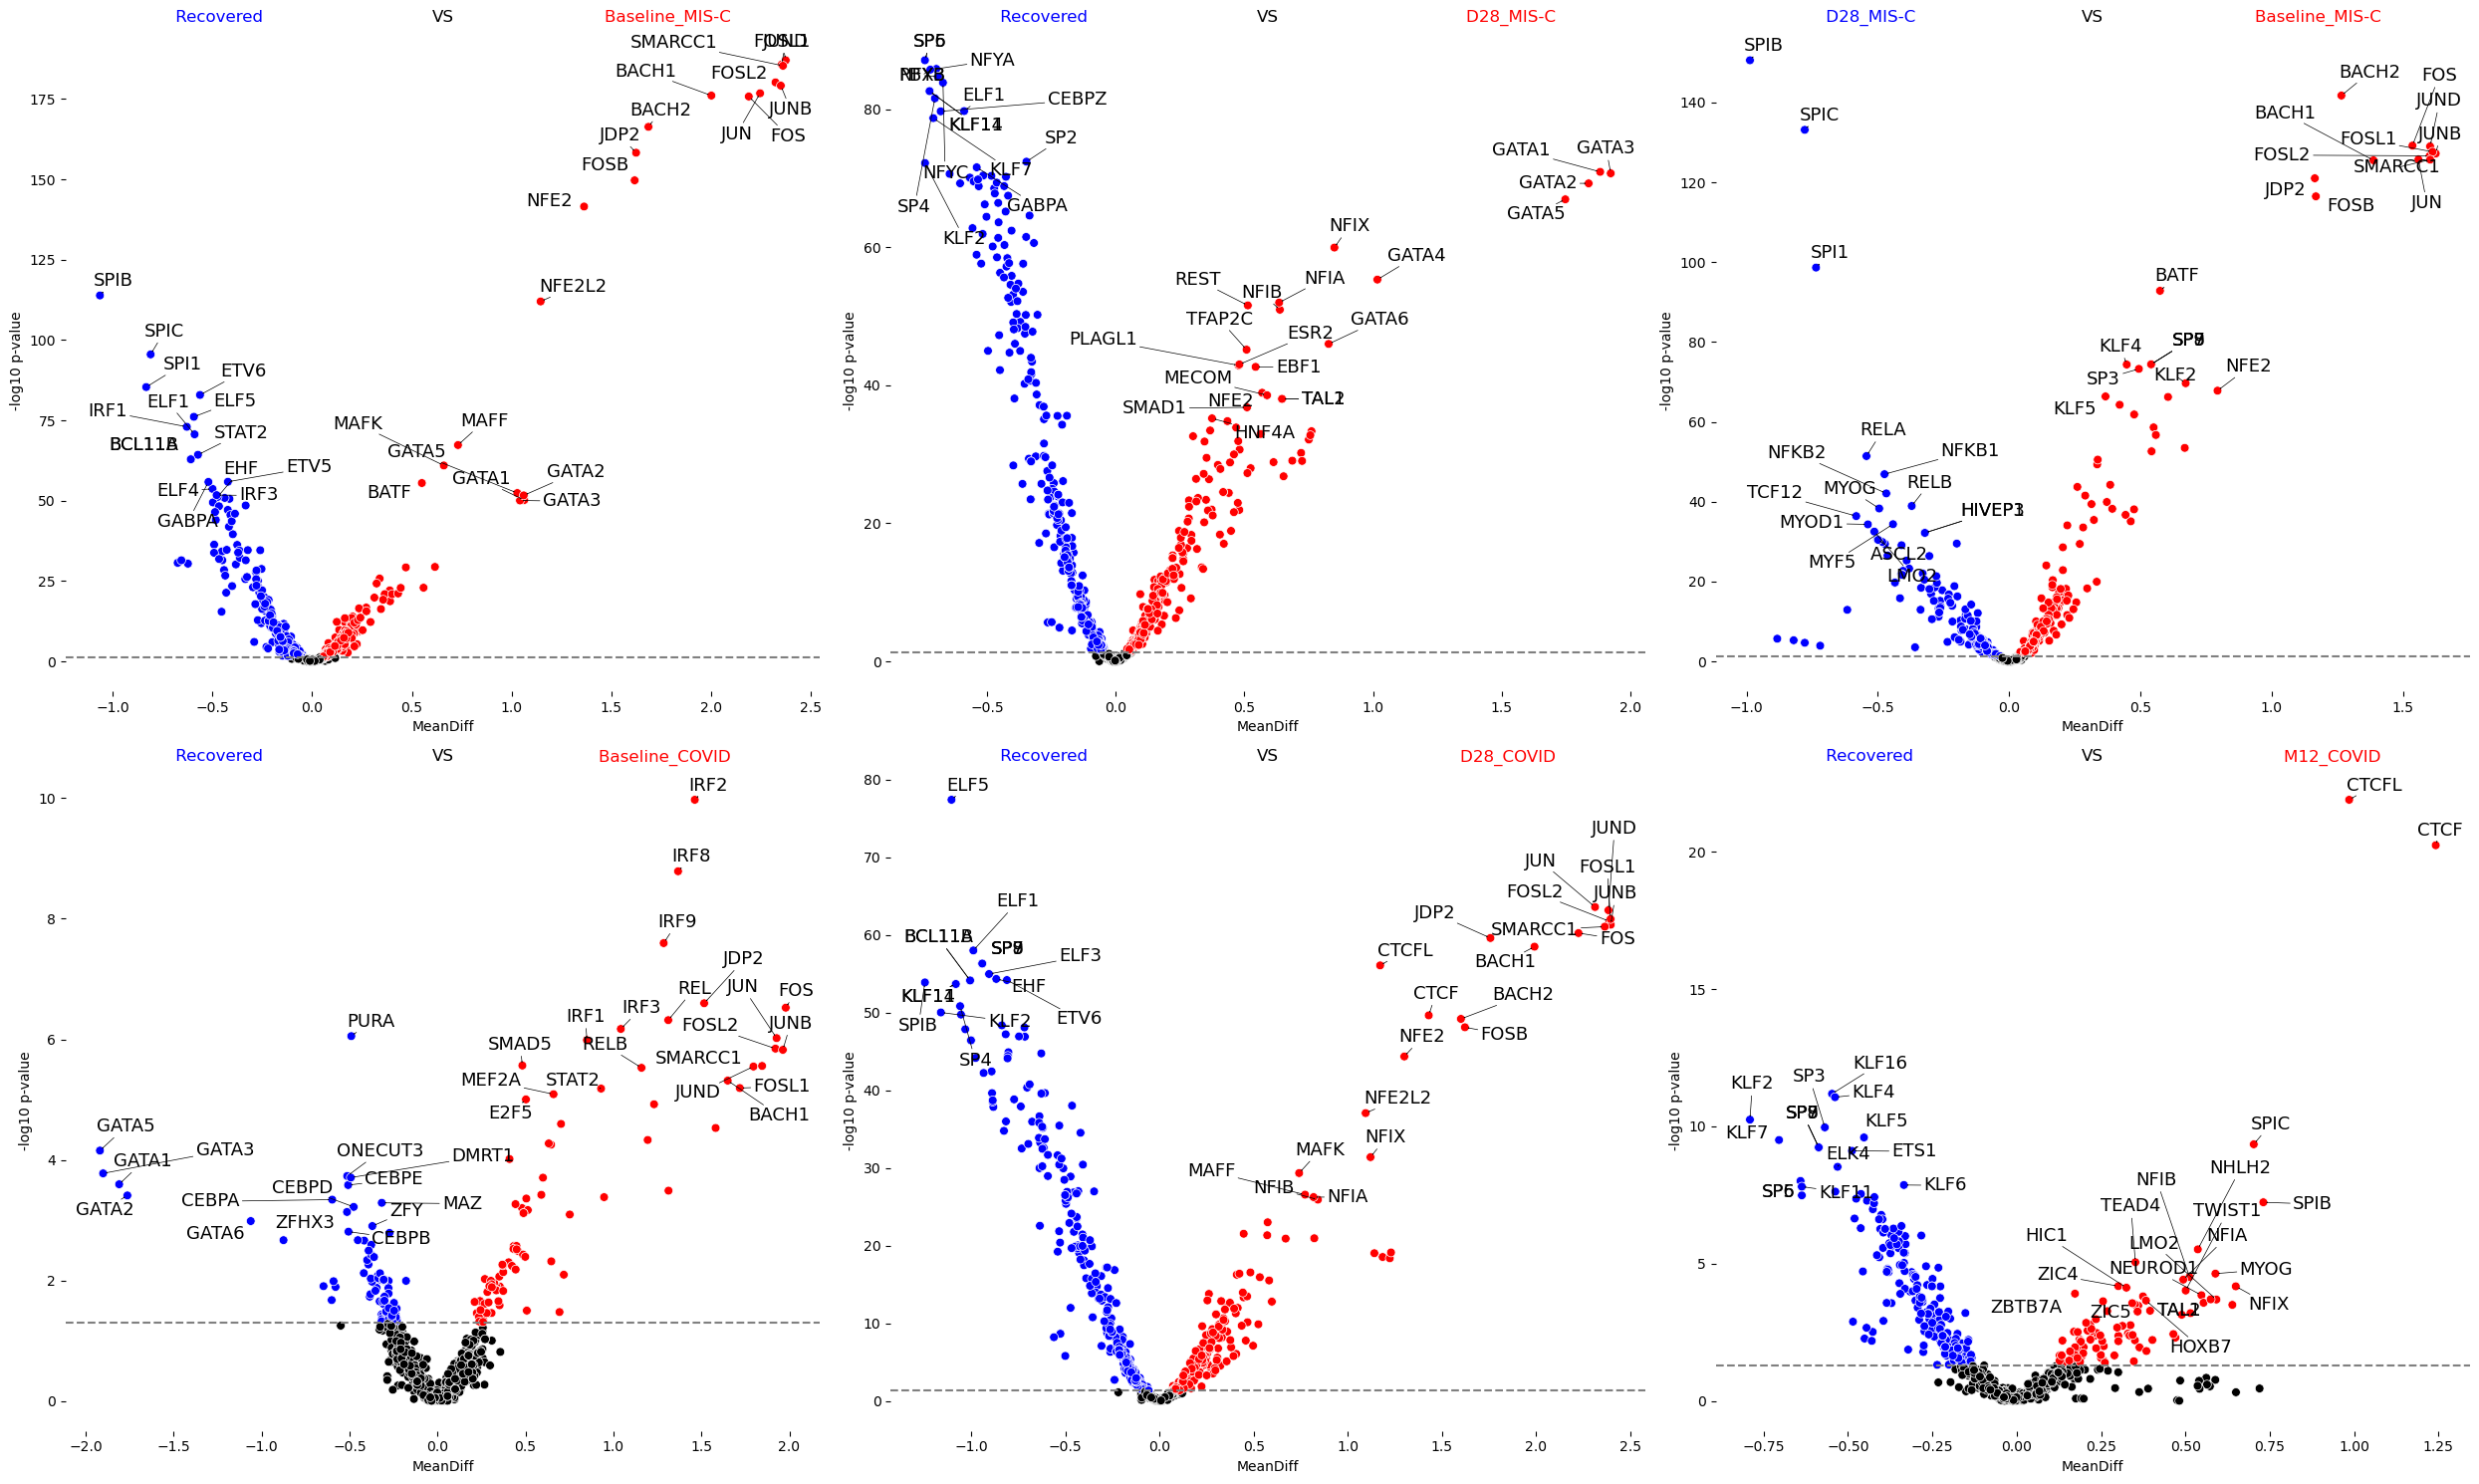

In [44]:
plot_data(data, title, nrows, ncols, output_dir, out_name='hspc_chromvar_volcano_plots.png'):

Individual groups

In [3]:
data = ['Recovered_VS_Baseline_MIS-C']
title = [['Recovered', 'Baseline_MIS-C']]
nrows = 1
ncols = 1

In [ ]:
plot_data(data, title, nrows, ncols, output_dir, out_name='hspc_chromvar_Recovered_VS_Baseline_MIS-C.png'):